# Generating the Dataset

### This set of code initiatives necessary libraries and reads in the simulated list of Naval Bases and billets. This will serve as an example of the Job owners information of potential opportunities for sailors. 

In [91]:
import pandas as pd
import random
import copy
from sklearn import preprocessing
import plotly.plotly as py
import plotly.graph_objs as go


#Read in the csv of Naval Base information: Name, Lat, Lon, Number of Billets
naval_bases = pd.read_csv("naval_bases.csv")

# Run the normalize the number of billets for the desired number of simulated sailors
naval_bases["Normalized"] = naval_bases["Billets"] / naval_bases["Billets"].sum()
naval_bases.head()

,Name,Billets,Lat,Lon,Normalized
0,CHINA LAKE NAVAL AIR WEAPONS STATION,5,35.66,-117.66,0.007082
1,CORONADO NAVAL AMPHIBIOUS BASE,10,32.68,-117.16,0.014164
2,EL CENTRO NAVAL AIR FACILITY,1,32.81,-115.67,0.001416
3,LEMOORE NAS,2,36.26,-119.91,0.002833
4,MONTEREY NAVAL POSTGRADUATE SCHOOL,2,36.60,-121.87,0.002833


### This section takes the desired number of billets to simulate and disperses them across a normalized range from the Naval Bases input csv.

In [92]:
#Total billets to simulate
total_billets = 1000

#Generate billets based on noramlized values
naval_bases["Billets"] = naval_bases["Normalized"] * total_billets
naval_bases["Billets"] = naval_bases["Billets"].astype("int")

#Get total billets simulated
assigned_billets = naval_bases["Billets"].sum()
print(assigned_billets)

976


### This section takes the desired number of sailors to simulate and randomly generates their top three preferences with a wighting based off of the number of available billets. This is to say that sailors prefer the locations with more available billets.

In [93]:
#Total sailors to simulate
total_sailors = 1500

#Randomly assign each sailor 3 preferences wieghted by the number of billets at each locaiton
sailor_prefernces = []
for i in range(total_sailors):
    sailor_prefernces.append(list(naval_bases.Name.sample(3, replace=False, weights=naval_bases.Billets)))
    sailor_prefernces[i].insert(0,i)
sailor_prefernces = pd.DataFrame(sailor_prefernces, columns=["sailor_ID", "pref_1","pref_2", "pref_3"])
print (len(sailor_prefernces))
sailor_prefernces.head()

1500


,sailor_ID,pref_1,pref_2,pref_3
0,0,"DAM NECK FLEET COMBAT TRAINING CENTER, ATLANTIC",NORFOLK NB,BEAUFORT NAVAL HOSPITAL
1,1,"DAM NECK FLEET COMBAT TRAINING CENTER, ATLANTIC",PORT HUENEME NAVAL CONSTRUCTION BATTALION CENTER,JACKSONVILLE NAS
2,2,NORFOLK NB,FLEET ANTISUBMARINE WARFARE TRAINING CENTER,JACKSONVILLE NAS
3,3,NORFOLK NB,NAVAL BASE CHARLESTON,MAYPORT NAVAL STATION
4,4,NORFOLK NB,SAN DIEGO NS,WHIDBEY ISLAND NAS


### This section takes all of the sailors interested in a given billet and then randomizes the job owners preferences for those sailors.

In [94]:
#Set up the job owner prefences, these are a randomized ordering of all sailors wanting to go to that billet
job_owner_prefernces = []
for base in list(naval_bases.Name):
    first = sailor_prefernces.loc[sailor_prefernces['pref_1'] == base]
    second = sailor_prefernces.loc[sailor_prefernces['pref_2'] == base]
    third = sailor_prefernces.loc[sailor_prefernces['pref_3'] == base]
    sailors = pd.concat([first,second,third]).drop_duplicates("sailor_ID", keep="first")
    job_owner_prefernces.append([base,list(sailors.sailor_ID)])
job_owner_prefernces = pd.DataFrame(job_owner_prefernces,columns=["job_owner", "sailors"])
job_owner_prefernces.head()

,job_owner,sailors
0,CHINA LAKE NAVAL AIR WEAPONS STATION,"[162, 189, 266, 396, 570, 748, 763, 776, 875, ..."
1,CORONADO NAVAL AMPHIBIOUS BASE,"[114, 223, 298, 461, 631, 657, 672, 730, 829, ..."
2,EL CENTRO NAVAL AIR FACILITY,"[659, 951, 1479, 356, 1421, 188, 824]"
3,LEMOORE NAS,"[31, 790, 1080, 1097, 1340, 192, 196, 611, 659..."
4,MONTEREY NAVAL POSTGRADUATE SCHOOL,"[559, 1438, 429, 543, 795, 317, 463, 519, 970,..."


### This section sums up the given sailors preferences for each of the potential commands

In [95]:
pref_1 = sailor_prefernces.groupby('pref_1').count()
pref_2 = sailor_prefernces.groupby('pref_2').count()
pref_3 = sailor_prefernces.groupby('pref_3').count()
naval_bases_hold = naval_bases.set_index("Name")
prefs = pd.concat([pref_1.sailor_ID, pref_2.sailor_ID,pref_3.sailor_ID,naval_bases_hold.Billets], axis=1)
prefs.columns = ["pref_1","pref_2","pref_3", "Billets"]
prefs.head()

,pref_1,pref_2,pref_3,Billets
ANNAPOLIS NS,21.0,19.0,23.0,14
BANGOR NAVAL SUBMARINE BASE,59.0,64.0,65.0,42
BEAUFORT NAVAL HOSPITAL,9.0,11.0,14.0,5
BETHESDA NATIONAL NAVAL MEDICAL CENTER,24.0,21.0,22.0,11
BREMERTON NAVAL STATION,25.0,17.0,24.0,14


### This section of code reshapes the various dataframes for running within the algorithm as well as for mapping.

In [96]:
#Shape dataframes into dictionaries for mathcing

#Sailors
sailor_prefernces_dict = sailor_prefernces.set_index('sailor_ID').T.to_dict('list')
sailor_prefernces_store = sailor_prefernces.set_index('sailor_ID').T.to_dict('list')

#Job Owners
job_owner_prefernces_dict = job_owner_prefernces.set_index('job_owner').T.to_dict('records')[0]

#Capacities
billets = pd.Series(naval_bases.Billets.values,index=naval_bases.Name).to_dict()

#Shape dataframes for graphing
#Billets
graph_bases = naval_bases.loc[naval_bases.index.repeat(naval_bases.Billets)]

### This section of code visualizes the available billets in a heatmap

In [29]:
import folium
from folium import plugins

m = folium.Map([41.8781, -87.6298], zoom_start=4)

# convert to (n, 2) nd-array format for heatmap
billet_loc = graph_bases[['Lat', 'Lon']].as_matrix()
# Add AOI to the markers***
billet_info = graph_bases["Name"].as_matrix()

# plot heatmap
hm = plugins.HeatMap(billet_loc.tolist(), name="Billet HeatMap")
m.add_child(hm)

# plot markers
hm = plugins.MarkerCluster(locations = billet_loc.tolist(), popups = billet_info.tolist(), name="Billets")
m.add_child(hm)

#Add Layer Control
# add the layer control
folium.LayerControl().add_to(m)


m

### This section of code runs through the algorithm to solve a stable marriage problem with given capacities for each of the suitors. 

The algorithm which solves this problem is famously utilised in the USA by the National Resident Matching Program, hence the nickname. In fact, research surrounding this algorithm won Shapley, along with Alvin Roth, the Nobel Prize for Economics in 2012. 

For our simulation, the hospitals will represent the represented job owners at each of the available commands. The residents will represent the sailors, and the capacities will be the number of billets available at each location. 



In [97]:
from collections import Counter
from copy import deepcopy

import numpy as np

def check_inputs(hospital_prefs, resident_prefs):
    """ Reduce as necessary the preference list of all residents and hospitals
    so that no player ranks another player that they are not also ranked by. """
    for resident in resident_prefs.keys():
        for hospital in resident_prefs[resident]:
            if resident not in hospital_prefs[hospital]:
                print (resident)
                print (hospital_prefs[hospital])
                raise ValueError(
                    'Hospitals must rank all residents who rank them.'
                )


def get_free_sailors(sailor_prefs, matching):
    """ Return a list of all sailors who are currently unmatched but have a
    non-empty preference list. """

    return [
        sailor
        for sailor in sailor_prefs
        if sailor_prefs[sailor]
        and not any([sailor in match for match in matching.values()])
    ]


def get_worst_idx(billet, owner_prefs, matching):
    """ Find the index of the worst sailor currently assigned to `billet`
    according to their preferences. """

    return max(
        [
            owner_prefs[billet].index(sailor)
            for sailor in owner_prefs[billet]
            if sailor in matching[billet]
        ]
    )


def dynamic_manning(owner_prefs, sailor_prefs, capacities):
    """ Provide a stable, sailor-optimal matching for the given instance of
    billet capacities using the algorithm set out in [Dubins, Freeman 1981]. """

    #Verify that all job owners and sailors have ranked each other
    check_inputs(owner_prefs, sailor_prefs)

    #Create an empty dictionary that contains all of the available billet options.
    # This will be what the algorithm returns
    matching = {billet: [] for billet in owner_prefs}
    
    #Get all of the available sailors left to be assigned
    free_sailors = get_free_sailors(sailor_prefs, matching)
    
    #This counter shows the number of interacitons that must be done in order to complete the algorithm
    count = 0
    
    #This loop continues as long as there are sailors left to be assigned
    while free_sailors:
        
        #Increase the counter for each time a new sailor needs to be assigned
        count += 1
        
        #Consider the sailor at the top, index 0, of the available sailors
        sailor = free_sailors[0]
        
        #Consider the top billet preference of the given sailor
        billet = sailor_prefs[sailor][0]
        
        #Add the sailor to their top billet in the output array
        matching[billet].append(sailor)
        
        #If there are more sailors assigned to this billet that positons available...
        if len(matching[billet]) > capacities[billet]:
            #Find the sailor who the job owner prefers the least currently in the job
            worst = get_worst_idx(billet, owner_prefs, matching)
            sailor = owner_prefs[billet][worst]
            
            #Remove them from this positoon
            matching[billet].remove(sailor)

        # If the billet is at capacity, and at this point the owner has filled all of their jobs
        if len(matching[billet]) == capacities[billet]:
            
            #Find the sailor who the job owner prefers the least currently in the job
            worst = get_worst_idx(billet, owner_prefs, matching)
            
            #Find all sailors who listed the billet in their preferences, 
            #but are less desired than those currently slated the job.
            successors = owner_prefs[billet][worst + 1:]

            #If there are any of these such sailors,
            if successors:
                
                #Iterate through them
                for resident in successors:
                    
                    #Increase the count for number of interations
                    count += 1
                    
                    #Remove each of the less desred sailors from the owners preferences
                    owner_prefs[billet].remove(sailor)
                    
                    #If the billet is in the sailors preferences,
                    if billet in sailor_prefs[resident]:
                        
                        #Remove the billet from the sailors preferences to manage memory later on
                        sailor_prefs[sailor].remove(billet)
                        
        #Get the number of free residents again and restart the while loop
        free_sailors = get_free_sailors(sailor_prefs, matching)

    #Organize all sailors by in their billets by owners preference for clarity
    for billet, matches in matching.items():
        sorted_matches = sorted(matches, key=owner_prefs[billet].index)
        matching[billet] = sorted_matches
    
    #Return matching data as well as interaction count
    return matching, count

#Run algorithm
match, count = dynamic_manning(job_owner_prefernces_dict, sailor_prefernces_dict, billets)


ValueError: list.remove(x): x not in list

### This section of code shows the breakdown of sailors and which preference they were allocated.

In [98]:
def check_inputs(hospital_prefs, resident_prefs):
    """ Reduce as necessary the preference list of all residents and hospitals
    so that no player ranks another player that they are not also ranked by. """

    for resident in resident_prefs.keys():
        for hospital in resident_prefs[resident]:
            if resident not in hospital_prefs[hospital]:
                raise ValueError(
                    'Hospitals must rank all residents who rank them.'
                )

def get_free_residents(resident_prefs, matching):
    """ Return a list of all residents who are currently unmatched but have a
    non-empty preference list. """

    return [
        resident
        for resident in resident_prefs
        if resident_prefs[resident]
        and not any([resident in match for match in matching.values()])
    ]


def get_worst_idx(hospital, hospital_prefs, matching):
    """ Find the index of the worst resident currently assigned to `hospital`
    according to their preferences. """

    return max(
        [
            hospital_prefs[hospital].index(resident)
            for resident in hospital_prefs[hospital]
            if resident in matching[hospital]
        ]
    )


def hospital_resident(hospital_prefs, resident_prefs, capacities):
    """ Provide a stable, resident-optimal matching for the given instance of
    HR using the algorithm set out in [Dubins, Freeman 1981]. """

    check_inputs(hospital_prefs, resident_prefs)

    matching = {hospital: [] for hospital in hospital_prefs}
    free_residents = get_free_residents(resident_prefs, matching)
    while free_residents:
        resident = free_residents[0]
        hospital = resident_prefs[resident][0]
        matching[hospital].append(resident)

        if len(matching[hospital]) > capacities[hospital]:
            worst = get_worst_idx(hospital, hospital_prefs, matching)
            resident = hospital_prefs[hospital][worst]
            matching[hospital].remove(resident)

        if len(matching[hospital]) == capacities[hospital]:
            worst = get_worst_idx(hospital, hospital_prefs, matching)
            successors = hospital_prefs[hospital][worst + 1:]

            if successors:
                for resident in successors:
                    hospital_prefs[hospital].remove(resident)
                    if hospital in resident_prefs[resident]:
                        resident_prefs[resident].remove(hospital)

        free_residents = get_free_residents(resident_prefs, matching)

    for hospital, matches in matching.items():
        sorted_matches = sorted(matches, key=hospital_prefs[hospital].index)
        matching[hospital] = sorted_matches

    return matching
match = hospital_resident(job_owner_prefernces_dict, sailor_prefernces_dict, billets)


                     Sailors
preference_received         
1                        975


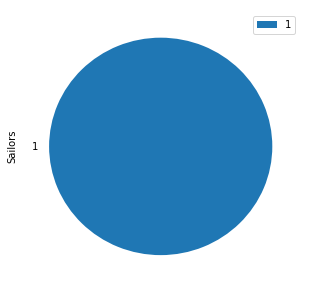

In [99]:
#verify Results and Show Preferences
sailor_results = []
for base, sailors in match.items():
    for member in sailors:
        prefernce = sailor_prefernces_store[member].index(base)
        sailor_results.append([member, prefernce + 1])
results = pd.DataFrame(sailor_results, columns=["Sailors", "preference_received"])
hold = results.groupby('preference_received').count()
print (hold)
plot = hold.plot.pie(y='Sailors', figsize=(5, 5))
plot

In [100]:
#Data Verification
flat_list = pd.Series([item for sublist in list(match.values()) for item in sublist])
print(flat_list.value_counts().max())
print(len(flat_list.values) - assigned_billets)

1
-1


In [101]:

owner_prefs

NameError: name 'owner_prefs' is not defined

In [85]:
owner_prefs

NameError: name 'owner_prefs' is not defined

In [52]:
test = [1,2,3,4,5,6,7,8]
worst = 2
successors = test[worst + 1:]


In [53]:
test[worst]

3

In [54]:
successors

[4, 5, 6, 7, 8]